# Image Classification Challenge

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Params
##################################################

#write path to your local folder where data are stored
os.chdir(r'C:\Users\Vittorino\Google Drive\Data Science - Unipd\I Year\II Semester\Algorithmic Methods and Machine Learning\Machine Learning\Project2\data')
currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = currentDirectory

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

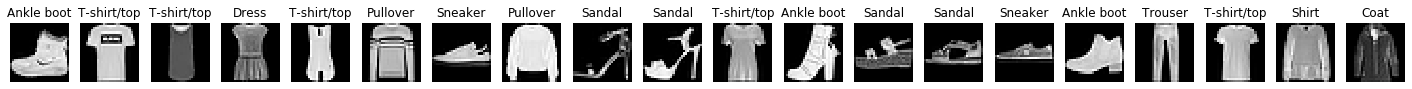

In [2]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [3]:
x_train.shape

(50000, 784)

# Overview

We are going to apply four different models:
- Logistic Regression
- KNN
- Random Forest
- Neural Networks

For each of them we apply the needed pre-processing of data and evaluate their performances.

In [4]:
##################################################
# Process the data here, if needed
##################################################

#since we are going to apply regularization, it's advisible to standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_train=x_train_scaled
x_valid=x_valid_scaled


# Model - Logistic Regression

### Pre-processing
In order to fit the data in a reasonable amount of time, we take 20% of observation in the train set to train the model.


In [ ]:
x_train_reduced=x_train[0:10000]
y_train_reduced=y_train[0:10000]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

### Model estimation

In [7]:
# Define the grid for the grid search
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]#inverse of regularization parameter = 1/lambda
solver = ['liblinear', 'saga']#the only two solver which support both l1 and l2 regularization
param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

{'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'saga']}


In [ ]:
##################################################
# Implement you model here
##################################################

logreg = LogisticRegression()
# grid search con 5 fold cross validation
grid_search = GridSearchCV(estimator=logreg,
                            param_grid=param_grid,
                            cv=cv,
                            n_jobs=-1)
grid_search.fit(x_train_reduced, y_train_reduced)

print(grid_search.best_params_)
print("Cross Validation Accuracy: %f" % grid_search.best_score_)

In [ ]:
# save the model to disk
filename = 'grid_search_Logistic.sav'
joblib.dump(grid_search, filename)

In [8]:
# to load the model from disk
filename = 'grid_search_Logistic.sav'
grid_search = joblib.load(filename)

In [9]:
# optimal hyperparameters
grid_search.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [10]:
#Performance in validation set of the optimal model 
grid_search.best_score_

0.8411

In [11]:
#performance in the test set of the optimal model trained in a subset of full train set
grid_search.score(x_valid, y_valid)

0.841

In [14]:
results_grid_search_logistic = pd.DataFrame(grid_search.cv_results_)
results_grid_search_logistic=results_grid_search_logistic[['params','mean_test_score','rank_test_score']]
results_grid_search_logistic

,params,mean_test_score,rank_test_score
0,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.0942,32
1,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'saga'}",0.1026,31
2,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.7431,28
3,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}",0.7692,24
4,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.3854,29
5,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.3780,30
6,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.7985,18
7,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.8268,13
8,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.7835,22
9,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.7869,20


### Train the model with the optimal hyperparameters on the full Training Set
Train the model with optimal hyperparameters found in the reduced training set, on the full train set.

In [15]:
logreg = LogisticRegression(penalty='l2',#ridge regularization
                            C=1,
                            solver='saga',
                            max_iter=1000)#with 1000 iterations converges
logreg.fit(x_train,y_train)

C:\Users\Vittorino\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Model evaluation

In [17]:
logreg.score(x_valid, y_valid)

0.8554

In [19]:
# save the model to disk
filename = 'LogisticRegr.sav'
joblib.dump(logreg, filename)

['LogisticRegr.sav']

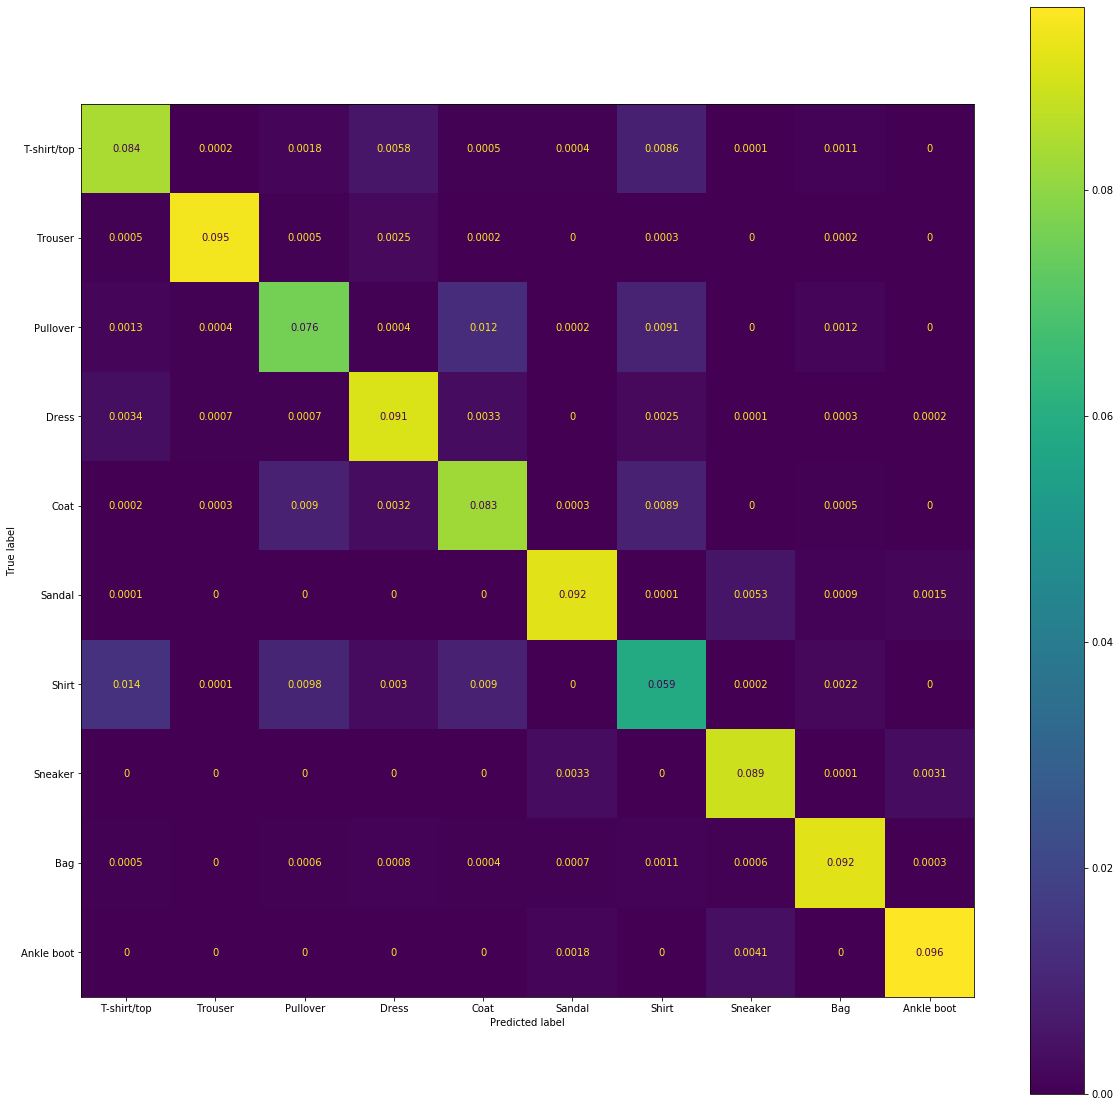

In [33]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(logreg, x_valid, y_valid,
                                     normalize='all', 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

# Model - KNN

### Pre-processing
For better numerical stability is advisible to divide by 255 each feature.


In [ ]:
x_train_reduced=x_train[0:10000]
y_train_reduced=y_train[0:10000]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

### Grid search (cross validated) on a downsampled version of the dataset
We use grid search to find the best value of k (='n_neighbors'). 

We do not look for the best value of $p$ in the $L_p$ metrics, because theorical 
results have prooved that the meaningfulness of the $L_p$ norm worsens faster within 
increasing dimensionality for higher values of $p$. Thus, for a given problem with a 
fixed (high) value for the dimensionality $d$, it is preferable to use lower values of $p$.
This means that the $L_1$ distance metric (Manhattan distance metric) is the most preferable 
for high dimensional applications, followed by the Euclidean metric ($L_2$).  
For reference see:

- Charu C. Aggarwal, Alexander Hinneburg, Daniel A. Keim, "On the Surprising Behavior of    Distance Metrics in High Dimensional Space"
- Kevin Beyer, Jonathan Goldstein, Raghu Ramakrishnan, Uri Shaft, "When Is 'Nearest Neighbor' Meaningful?"

# Model - Random Forest

### Pre-processing

### Model estimation

### Model evaluation

# Model - Neural Network

### Pre-processing

### Model estimation

### Model evaluation